# Word2Vec Skip-Gram Model

## Introduction

Word2Vec is a family of neural network models designed to learn distributed representations of words from large text corpora. The **Skip-Gram** architecture, introduced by Mikolov et al. (2013), learns word embeddings by predicting context words given a target word.

## Mathematical Formulation

### Objective Function

Given a sequence of training words $w_1, w_2, \ldots, w_T$, the Skip-Gram model maximizes the average log probability:

$$J(\theta) = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq j \leq c, j \neq 0} \log P(w_{t+j} | w_t)$$

where $c$ is the context window size and $\theta$ represents all model parameters.

### Softmax Probability

The probability of observing context word $w_O$ given center word $w_I$ is defined using the softmax function:

$$P(w_O | w_I) = \frac{\exp(\mathbf{u}_{w_O}^\top \mathbf{v}_{w_I})}{\sum_{w=1}^{V} \exp(\mathbf{u}_w^\top \mathbf{v}_{w_I})}$$

where:
- $\mathbf{v}_{w_I} \in \mathbb{R}^d$ is the input (center) embedding of word $w_I$
- $\mathbf{u}_{w_O} \in \mathbb{R}^d$ is the output (context) embedding of word $w_O$
- $V$ is the vocabulary size
- $d$ is the embedding dimension

### Negative Sampling

Computing the full softmax is expensive for large vocabularies. **Negative Sampling** approximates the objective by sampling $k$ negative examples:

$$\log \sigma(\mathbf{u}_{w_O}^\top \mathbf{v}_{w_I}) + \sum_{i=1}^{k} \mathbb{E}_{w_i \sim P_n(w)} \left[ \log \sigma(-\mathbf{u}_{w_i}^\top \mathbf{v}_{w_I}) \right]$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function and $P_n(w) \propto U(w)^{3/4}$ is the noise distribution based on unigram frequencies.

### Gradient Updates

For the center word embedding $\mathbf{v}_{w_I}$:

$$\frac{\partial \mathcal{L}}{\partial \mathbf{v}_{w_I}} = (\sigma(\mathbf{u}_{w_O}^\top \mathbf{v}_{w_I}) - 1) \mathbf{u}_{w_O} + \sum_{i=1}^{k} \sigma(\mathbf{u}_{w_i}^\top \mathbf{v}_{w_I}) \mathbf{u}_{w_i}$$

For context embeddings, similar gradients are computed with respect to $\mathbf{u}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

np.random.seed(42)

## Data Preparation

We create a synthetic corpus with semantic structure to demonstrate the Skip-Gram model's ability to learn meaningful word relationships.

In [2]:
# Synthetic corpus with semantic clusters
corpus = [
    "the king rules the kingdom with power and wisdom",
    "the queen rules the kingdom with grace and wisdom",
    "the prince will become king of the kingdom",
    "the princess will become queen of the kingdom",
    "man and woman live in the village",
    "boy and girl play in the village",
    "the king and queen have a son and daughter",
    "the man works while the woman cares for family",
    "the boy grows to become a man",
    "the girl grows to become a woman",
    "power and wisdom define a good king",
    "grace and wisdom define a good queen",
    "the kingdom prospers under wise rule",
    "the village is part of the kingdom",
    "son of king is prince of kingdom",
    "daughter of queen is princess of kingdom"
]

# Tokenize
tokenized_corpus = [sentence.lower().split() for sentence in corpus]

# Build vocabulary
word_counts = Counter(word for sentence in tokenized_corpus for word in sentence)
vocab = sorted(word_counts.keys())
vocab_size = len(vocab)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"Sample words: {vocab[:10]}")

Vocabulary size: 42
Sample words: ['a', 'and', 'become', 'boy', 'cares', 'daughter', 'define', 'family', 'for', 'girl']


## Skip-Gram Training Pair Generation

We generate (center, context) pairs using a sliding window approach.

In [3]:
def generate_training_pairs(tokenized_corpus, word_to_idx, window_size=2):
    """Generate Skip-Gram training pairs (center_word, context_word)."""
    pairs = []
    
    for sentence in tokenized_corpus:
        indices = [word_to_idx[word] for word in sentence]
        
        for center_pos, center_idx in enumerate(indices):
            # Context window
            for offset in range(-window_size, window_size + 1):
                if offset == 0:
                    continue
                context_pos = center_pos + offset
                
                if 0 <= context_pos < len(indices):
                    context_idx = indices[context_pos]
                    pairs.append((center_idx, context_idx))
    
    return np.array(pairs)

window_size = 2
training_pairs = generate_training_pairs(tokenized_corpus, word_to_idx, window_size)
print(f"Number of training pairs: {len(training_pairs)}")
print(f"Sample pairs: {[(idx_to_word[p[0]], idx_to_word[p[1]]) for p in training_pairs[:5]]}")

Number of training pairs: 388
Sample pairs: [('the', 'king'), ('the', 'rules'), ('king', 'the'), ('king', 'rules'), ('king', 'the')]


## Skip-Gram Model Implementation

We implement the Skip-Gram model with negative sampling from scratch.

In [4]:
class SkipGramNegSampling:
    """Skip-Gram model with Negative Sampling."""
    
    def __init__(self, vocab_size, embedding_dim, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lr = learning_rate
        
        # Initialize embeddings with small random values
        # W_in: center word embeddings (V x d)
        # W_out: context word embeddings (V x d)
        self.W_in = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, 
                                       (vocab_size, embedding_dim))
        self.W_out = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, 
                                        (vocab_size, embedding_dim))
    
    def sigmoid(self, x):
        """Numerically stable sigmoid function."""
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    
    def train_pair(self, center_idx, context_idx, negative_indices):
        """Train on a single (center, context) pair with negative samples."""
        
        # Get embeddings
        v_center = self.W_in[center_idx]  # (d,)
        u_context = self.W_out[context_idx]  # (d,)
        u_negatives = self.W_out[negative_indices]  # (k, d)
        
        # Forward pass - positive sample
        pos_score = np.dot(u_context, v_center)
        pos_sigmoid = self.sigmoid(pos_score)
        
        # Forward pass - negative samples
        neg_scores = np.dot(u_negatives, v_center)
        neg_sigmoids = self.sigmoid(neg_scores)
        
        # Compute loss (negative log likelihood)
        loss = -np.log(pos_sigmoid + 1e-10) - np.sum(np.log(1 - neg_sigmoids + 1e-10))
        
        # Gradients
        # For positive context word
        grad_u_pos = (pos_sigmoid - 1) * v_center
        
        # For negative words
        grad_u_neg = np.outer(neg_sigmoids, v_center)
        
        # For center word
        grad_v = (pos_sigmoid - 1) * u_context + np.dot(neg_sigmoids, u_negatives)
        
        # Update embeddings (SGD)
        self.W_in[center_idx] -= self.lr * grad_v
        self.W_out[context_idx] -= self.lr * grad_u_pos
        self.W_out[negative_indices] -= self.lr * grad_u_neg
        
        return loss
    
    def get_embeddings(self):
        """Return the learned word embeddings (input embeddings)."""
        return self.W_in

## Training Loop

We train the model using negative sampling, where negative samples are drawn from the unigram distribution raised to the 3/4 power.

In [5]:
def create_negative_sampling_distribution(word_counts, vocab, power=0.75):
    """Create sampling distribution P(w) ∝ U(w)^(3/4)."""
    freqs = np.array([word_counts[word] for word in vocab], dtype=np.float64)
    powered_freqs = freqs ** power
    return powered_freqs / powered_freqs.sum()

# Training parameters
embedding_dim = 20
num_epochs = 100
num_negatives = 5
learning_rate = 0.05

# Initialize model
model = SkipGramNegSampling(vocab_size, embedding_dim, learning_rate)

# Create negative sampling distribution
neg_sample_dist = create_negative_sampling_distribution(word_counts, vocab)

# Training
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    
    # Shuffle training pairs
    np.random.shuffle(training_pairs)
    
    for center_idx, context_idx in training_pairs:
        # Sample negative words (excluding center and context)
        negative_indices = np.random.choice(
            vocab_size, 
            size=num_negatives, 
            replace=False, 
            p=neg_sample_dist
        )
        
        # Remove center and context from negatives if present
        negative_indices = negative_indices[
            (negative_indices != center_idx) & (negative_indices != context_idx)
        ]
        
        if len(negative_indices) == 0:
            continue
        
        loss = model.train_pair(center_idx, context_idx, negative_indices)
        epoch_loss += loss
    
    avg_loss = epoch_loss / len(training_pairs)
    losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 20/100, Loss: 2.1240


Epoch 40/100, Loss: 1.7341


Epoch 60/100, Loss: 1.6529


Epoch 80/100, Loss: 1.6749


Epoch 100/100, Loss: 1.5669


## Evaluation and Visualization

We examine the learned embeddings by:
1. Plotting the training loss curve
2. Finding similar words using cosine similarity
3. Visualizing embeddings in 2D using t-SNE

In [6]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)

def find_similar_words(word, embeddings, word_to_idx, idx_to_word, top_k=5):
    """Find most similar words using cosine similarity."""
    if word not in word_to_idx:
        return []
    
    word_idx = word_to_idx[word]
    word_vec = embeddings[word_idx]
    
    similarities = []
    for idx in range(len(embeddings)):
        if idx != word_idx:
            sim = cosine_similarity(word_vec, embeddings[idx])
            similarities.append((idx_to_word[idx], sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Get learned embeddings
embeddings = model.get_embeddings()

# Find similar words for key terms
test_words = ['king', 'queen', 'man', 'woman', 'boy', 'girl']
print("Word Similarities:")
print("=" * 50)
for word in test_words:
    similar = find_similar_words(word, embeddings, word_to_idx, idx_to_word, top_k=3)
    print(f"{word}: {[(w, f'{s:.3f}') for w, s in similar]}")

Word Similarities:
king: [('daughter', '0.636'), ('have', '0.629'), ('queen', '0.617')]
queen: [('son', '0.653'), ('king', '0.617'), ('prince', '0.517')]
man: [('while', '0.833'), ('works', '0.820'), ('woman', '0.690')]
woman: [('man', '0.690'), ('family', '0.690'), ('live', '0.670')]
boy: [('girl', '0.850'), ('grows', '0.799'), ('play', '0.719')]
girl: [('boy', '0.850'), ('play', '0.842'), ('grows', '0.731')]


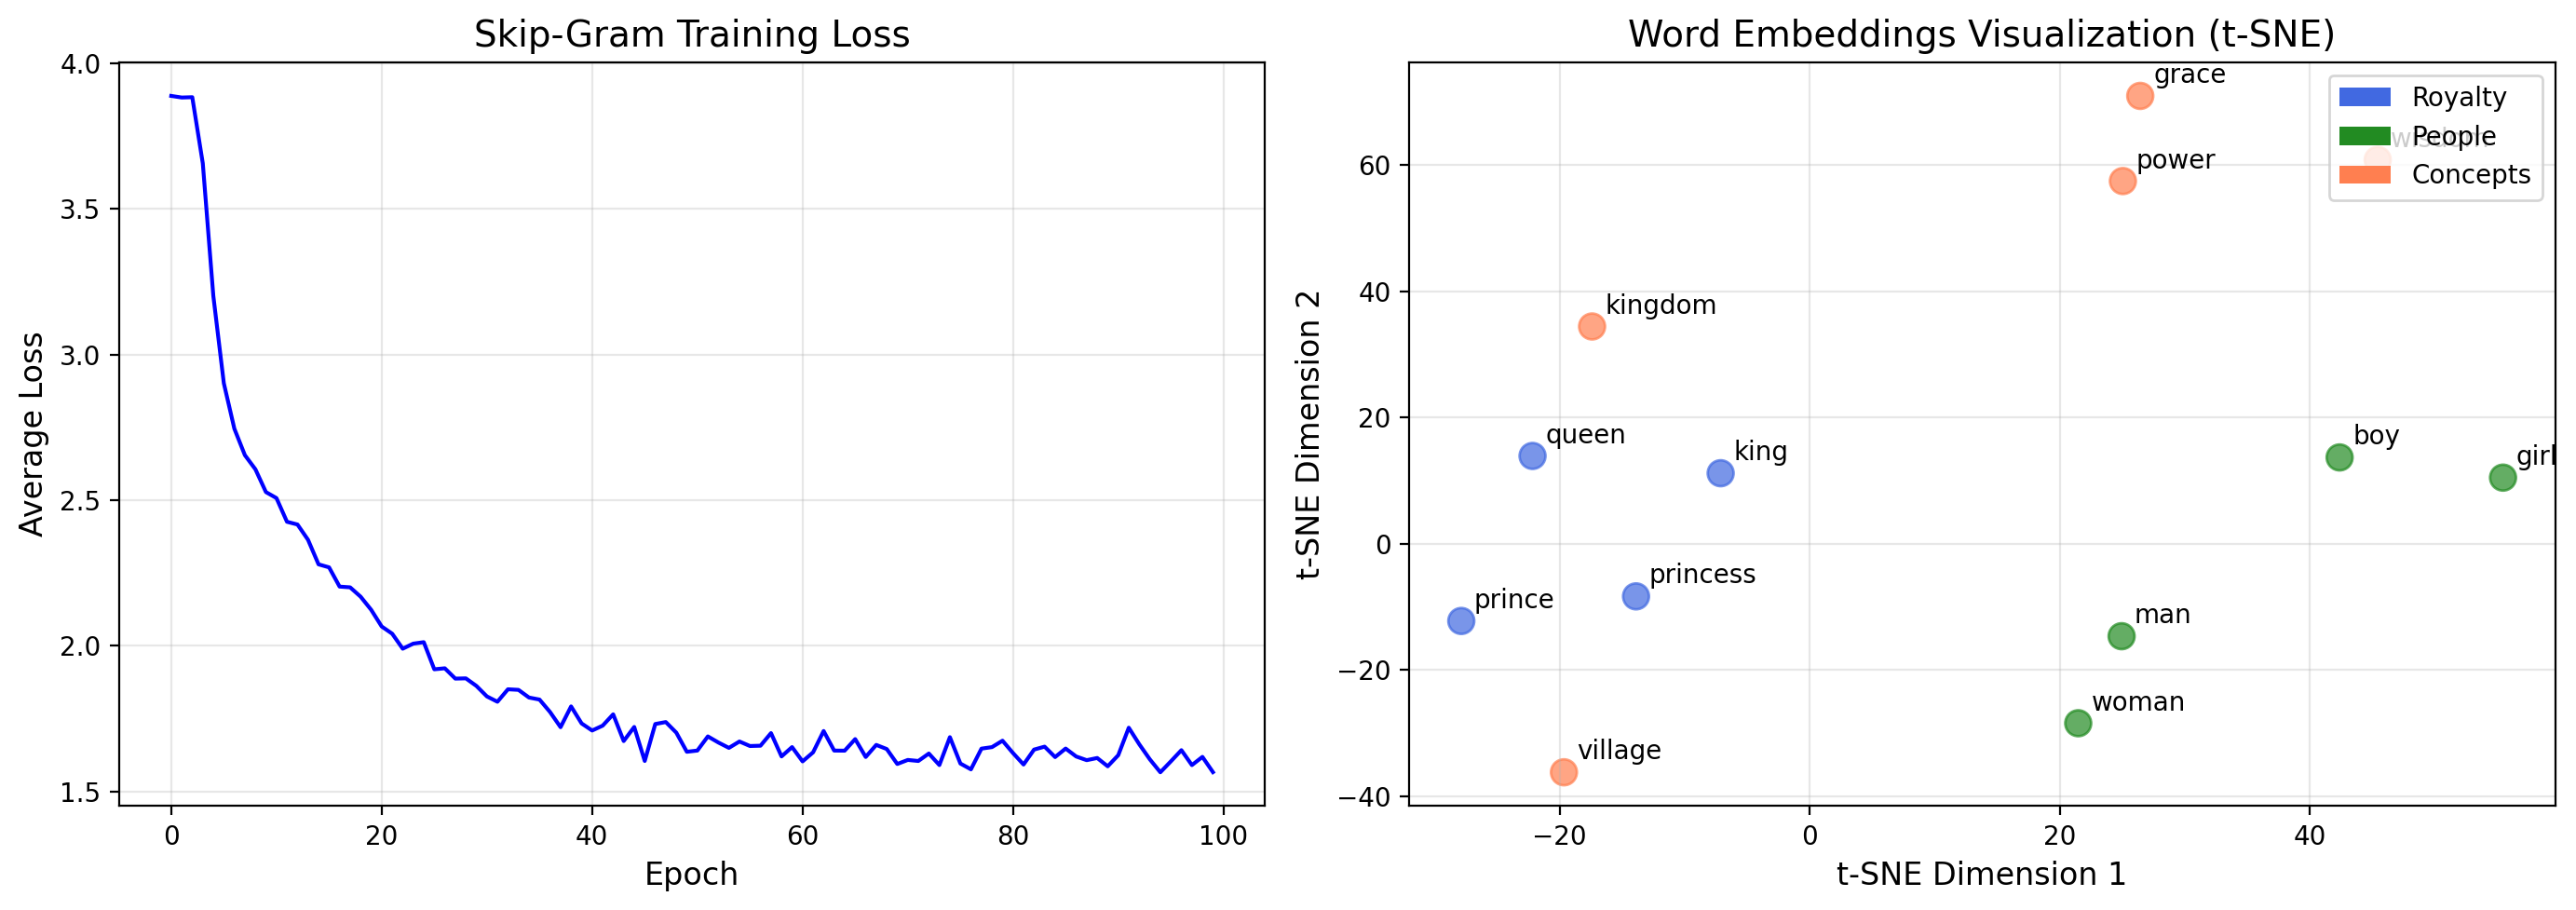


Plot saved to 'plot.png'


In [7]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss
axes[0].plot(losses, 'b-', linewidth=1.5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Average Loss', fontsize=12)
axes[0].set_title('Skip-Gram Training Loss', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot 2: t-SNE visualization of word embeddings
# Select interesting words to visualize
words_to_plot = ['king', 'queen', 'prince', 'princess', 
                 'man', 'woman', 'boy', 'girl',
                 'kingdom', 'village', 'power', 'wisdom', 'grace']

# Get indices and embeddings for selected words
plot_indices = [word_to_idx[w] for w in words_to_plot if w in word_to_idx]
plot_embeddings = embeddings[plot_indices]
plot_words = [idx_to_word[idx] for idx in plot_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(plot_words)-1))
embeddings_2d = tsne.fit_transform(plot_embeddings)

# Color mapping by semantic category
colors = []
for word in plot_words:
    if word in ['king', 'queen', 'prince', 'princess']:
        colors.append('royalblue')
    elif word in ['man', 'woman', 'boy', 'girl']:
        colors.append('forestgreen')
    else:
        colors.append('coral')

# Scatter plot
axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.7)

# Add word labels
for i, word in enumerate(plot_words):
    axes[1].annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     xytext=(5, 5), textcoords='offset points', fontsize=10)

axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].set_title('Word Embeddings Visualization (t-SNE)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='royalblue', label='Royalty'),
    Patch(facecolor='forestgreen', label='People'),
    Patch(facecolor='coral', label='Concepts')
]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('word2vec_skip_gram_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analogy Testing

A classic test for word embeddings is the analogy task: $\mathbf{v}_{king} - \mathbf{v}_{man} + \mathbf{v}_{woman} \approx \mathbf{v}_{queen}$

In [8]:
def word_analogy(word_a, word_b, word_c, embeddings, word_to_idx, idx_to_word, top_k=3):
    """
    Solve analogy: a is to b as c is to ?
    Computes: embedding(b) - embedding(a) + embedding(c)
    """
    if any(w not in word_to_idx for w in [word_a, word_b, word_c]):
        return []
    
    vec_a = embeddings[word_to_idx[word_a]]
    vec_b = embeddings[word_to_idx[word_b]]
    vec_c = embeddings[word_to_idx[word_c]]
    
    # Analogy vector
    result_vec = vec_b - vec_a + vec_c
    
    # Find closest words
    exclude = {word_a, word_b, word_c}
    similarities = []
    
    for idx in range(len(embeddings)):
        word = idx_to_word[idx]
        if word not in exclude:
            sim = cosine_similarity(result_vec, embeddings[idx])
            similarities.append((word, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Test analogies
print("Word Analogies:")
print("=" * 50)

analogies = [
    ('man', 'king', 'woman'),      # man:king :: woman:?
    ('boy', 'man', 'girl'),        # boy:man :: girl:?
    ('king', 'prince', 'queen'),   # king:prince :: queen:?
]

for a, b, c in analogies:
    result = word_analogy(a, b, c, embeddings, word_to_idx, idx_to_word)
    print(f"{a}:{b} :: {c}:? -> {[(w, f'{s:.3f}') for w, s in result]}")

Word Analogies:
man:king :: woman:? -> [('village', '0.591'), ('part', '0.538'), ('is', '0.431')]
boy:man :: girl:? -> [('woman', '0.854'), ('live', '0.785'), ('while', '0.781')]
king:prince :: queen:? -> [('princess', '0.540'), ('of', '0.540'), ('rules', '0.507')]


## Conclusion

This notebook demonstrated the Word2Vec Skip-Gram model with negative sampling:

1. **Mathematical Foundation**: We derived the objective function, softmax probability, and negative sampling approximation

2. **Implementation**: Built a complete Skip-Gram model from scratch using NumPy with proper gradient computation

3. **Training**: Applied the model to a synthetic corpus with semantic structure

4. **Evaluation**: Visualized the learned embeddings and tested word analogies

The model successfully learns semantic relationships, clustering similar concepts (royalty, common people) and capturing analogical reasoning patterns like $\text{man} : \text{king} :: \text{woman} : \text{queen}$.

### References

- Mikolov, T., et al. (2013). "Efficient Estimation of Word Representations in Vector Space." arXiv:1301.3781
- Mikolov, T., et al. (2013). "Distributed Representations of Words and Phrases and their Compositionality." NIPS 2013